In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style

This notebook is intended to make plotting of the PyGEM-EB output straightforward for fast diagnostics after a model run. Most functions just need the information for the model run in the cell below. 

In [2]:
# Filepath to the model run output
file = '/home/claire/research/Output/EB/run_2023_06_26_hourly_00.nc'
# Some functions only plot a single elevation bin
bin = 1

Specify the plotting style to use and the figure name to save the plot.

In [3]:
# Define additional plotting variables
style.use('seaborn')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 
today = str(pd.Timestamp.today()).replace('-','_')[0:10]
figname = 'Figure'+today+'.png'

Run the following cells to plot the data. For information on any of the plotting functions, run 'help(name_of_function)'. Available functions are:
- plot_avgs
- plot_yrs
- plot_avg_layers
- plot_layers_monthly

In [4]:
# Load in the data and define the number of years in the model run
ds = xr.open_dataset(file)
startdate = pd.to_datetime(ds.indexes['time'].to_numpy()[0])
enddate = pd.to_datetime(ds.indexes['time'].to_numpy()[-1])
nyr = enddate.year-startdate.year

In [5]:
def plot_avgs(file,nyr):
    """
    Plots heat fluxes, surface/air temperature, and mass balance terms, averaged monthly and then interannually.
    """
    months = np.arange(1,13)

    fig,axes = plt.subplots(3,3,sharex=True,sharey='row',figsize=(12,6))

    ds = xr.open_dataset(file)
    varnames_idx = ['SWin','SWout','LWin','LWout','sensible','latent','rain','meltenergy','surftemp','melt','runoff','refreeze','accum']
    varnames = ['SWnet','LWnet','sensible','latent','rain','meltenergy','surftemp','melt','runoff','refreeze','accum']
    heat = ['SWnet','LWnet','sensible','latent','rain','meltenergy']
    temp = ['surftemp']
    mb = ['melt','runoff','refreeze','accum','MB']

    airtemp = np.zeros((3,12))
    for b in range(3):
        climatedf = xr.open_dataset('/home/claire/research/Output/EB/climateds.nc').isel(bin=b).to_pandas()
        monthly = climatedf['bin_temp'].resample('M').mean()
        monthly_avg = np.mean(monthly[:(nyr*12)].values.reshape((nyr,12)),axis=0)
        airtemp[b,:] = monthly_avg

    for bin_no in [0,1,2]:
        df = ds[varnames_idx].isel(bin=bin_no).to_pandas()
        df['SWnet'] = df['SWin'] + df['SWout']
        df['LWnet'] = df['LWin'] + df['LWout']
        df['melt'] = df['melt'] * -1
        
        for var in varnames:
            if var in ['melt','runoff','refreeze','accum','MB']:
                monthly = df[var].resample('M').sum()
            else:
                monthly = df[var].resample('M').mean()
            monthly_avg = np.mean(monthly[:(nyr*12)].values.reshape((nyr,12)),axis=0)
            run_start_month = pd.Timestamp(ds.coords['time'].values[0]).month
            if run_start_month > 1:
                monthly_avg_jan = np.append(monthly_avg[13-run_start_month:],monthly_avg[:13-run_start_month],)

            axis = np.piecewise(var,[var in heat, var in temp, var in mb],[0,1,2])
            lw = 1 if var in ['meltenergy','surftemp'] else 0.5
            axes[int(axis),bin_no].plot(months,monthly_avg_jan,label=var,linewidth=lw)
        axes[1,bin_no].plot(months,airtemp[bin_no,:],linewidth=0.5,label='air temp')
        axes[1,bin_no].axhline(0,lw=0.3,color='gray')
        axes[bin_no,2].set_xticks(months)
    axes[0,0].set_ylabel('Energy Flux ($W / m^2$)')
    axes[1,0].set_ylabel('Temperature (C)')
    axes[2,0].set_ylabel('Mass balance (m w.e.)')

    binname = ['Lower','Middle','Upper']
    for i in range(3):
        axes[0,i].set_title(binname[i])
    axes[0,0].legend(loc='upper right',bbox_to_anchor=(1.25, 1.0))
    axes[1,0].legend()
    axes[2,0].legend()
    fig.suptitle(f'Gulkana Glacier (ERA5-Hourly)\nMonthly Averages Over {nyr}-yr Run')
    fig.supxlabel('Months')
    #plt.gcf().autofmt_xdate()
    plt.show()

In [6]:
def plot_yrs(file,bin,nyr):
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    fig,axes = plt.subplots(nyr,3,sharex=True,sharey='col',figsize=(14,8))

    ds = xr.open_dataset(file)
    varnames_idx = ['SWin','SWout','LWin','LWout','sensible','latent','rain','meltenergy','surftemp','melt','runoff','refreeze','accum','snowdepth']
    varnames = ['SWnet','LWnet','sensible','latent','rain','meltenergy','surftemp','melt','runoff','refreeze','accum','snowdepth']
    heat = ['SWnet','LWnet','sensible','latent','rain','meltenergy']
    temp = ['surftemp','snowdepth']
    mb = ['melt','runoff','refreeze','accum','MB']

    df = ds[varnames_idx].isel(bin=bin).to_pandas()
    df['SWnet'] = df['SWin'] + df['SWout']
    df['LWnet'] = df['LWin'] + df['LWout']
    df['MB'] = df['accum']+df['refreeze']-df['melt']

    # Loop through variables to get monthly averages and plot them
    for var in varnames:
        if var in ['melt','runoff','refreeze','accum','MB']:
            monthly = df[var].resample('M').sum()
        else:
            monthly = df[var].resample('M').mean()
        monthly_avg = monthly[:(nyr*12)].values.reshape((nyr,12))
        
        axis = np.piecewise(var,[var in heat, var in temp, var in mb],[0,1,2])
        for yr in range(nyr):
            axes[yr,int(axis)].plot(months,monthly_avg[yr,:])
            axes[yr,int(axis)].set_xlabel(str(1980+yr))
            axes[yr,int(axis)].set_ylabel(var)

In [7]:
def plot_avg_layers(file,bin,nyr):
    """
    Plots layer temperature, density, water content and layer height averaged first across all layers,
    then averaged between years. 
    """
    ds = xr.open_dataset(file)
    fig,axes = plt.subplots(2,2,sharex=True,figsize=(8,6)) #,sharex=True,sharey='row',figsize=(12,5)
    idxs = [[0,0],[0,1],[1,0],[1,1]]
    days =  np.arange(365)
    for ax,var in enumerate(['snowtemp','snowdensity','watercont','snowdepth']):
        snow = ds[var].sel(bin=bin).to_pandas()
        loop = True
        i=19
        while loop:
            if np.isnan(snow.iloc[i]).all and var not in ['snowdepth']:
                snow.drop(i,axis=1)
            i -=1
            if i == 0:
                break

        if var in ['snowtemp','snowdensity']:
            snow = snow.mean(axis=1)
        elif var in ['snowdepth']:
            pass
        else:
            snow = snow.sum(axis=1)
        if var in ['watercont']:
            snow = snow/1000 # to m w.e.
        snowdaily = snow.resample('d').mean()
        snowdaily = np.mean(snow[:nyr*365].values.reshape((nyr,365)),axis=0)

        idx = idxs[ax]
        axes[idx[0],idx[1]].plot(days,snowdaily,label=var)
        axes[idx[0],idx[1]].set_title(var+'   '+ds[var].attrs['units'])
    axes[1,0].set_title('water content    m w .e')
    plt.gcf().autofmt_xdate()
    # plt.savefig('/home/claire/research/Output/EB/subsurfplot.png')
    plt.show()

In [8]:
def plot_layers_monthly(file,var,months_to_plot):
    ds = xr.open_dataset(file)
    fig,axes = plt.subplots(1,len(months_to_plot),sharey=True,sharex=True,figsize=(8,4)) #,sharex=True,sharey='row'
    df = ds['snowdepth'].to_pandas()
    snowdepth_monthly = df.resample('M').mean()

    # for each month, find average snow depth
    # interpolate the variable of interest at new depths, with max depth being the average snow depth of the month
    # take mean of resampled variables
    # plot new depths vs. monthly means
    ax=0
    for month in range(12):
        snowdepth = snowdepth_monthly.iloc[month]
        for bin_no in [0,1,2]:
            var_data = ds[var].isel(bin=bin_no).to_numpy()
            depth_data = ds['layerheight'].isel(bin=bin_no).to_numpy()
            new_depths = np.linspace(0,snowdepth.iloc[bin_no],20)

            zeros = np.zeros((len(ds.coords['time'].values),20))
            var_interp = zeros.copy()
            for i,t in enumerate(ds.coords['time'].values):
                var_interp[i,:] = np.interp(new_depths,depth_data[i,:],var_data[i,:])
            da = xr.DataArray(data=var_interp,
                    coords=dict(
                        time=(['time'],ds.coords['time'].values),
                        depth=(['depth'],new_depths)
                        ))
            da_monthly = da.resample(time='M').mean()
            if month in months_to_plot:
                axes[ax].plot(da.isel(time=month).data,-1*da.coords['depth'].values,label='Bin '+str(bin_no))
        if month in months_to_plot: 
            axes[ax].set_xlabel(var)
            axes[0].set_ylabel('Depth (m)')
            month_dict = {'0':'Jan','1':'Feb','2':'Mar','3':'Apr','4':'May','5':'Jun',
                        '6':'Jul','7':'Aug','8':'Sept','9':'Oct','10':'Nov','11':'Dec'}
            axes[ax].set_title(month_dict[str(month)])
            axes[ax].axhline(-snowdepth[0],color=colors[0],linestyle='--')
            axes[ax].axhline(-snowdepth[1],color=colors[1],linestyle='--')
            axes[ax].axhline(-snowdepth[2],color=colors[2],linestyle='--')
            ax += 1
    axes[len(months_to_plot)-1].legend()

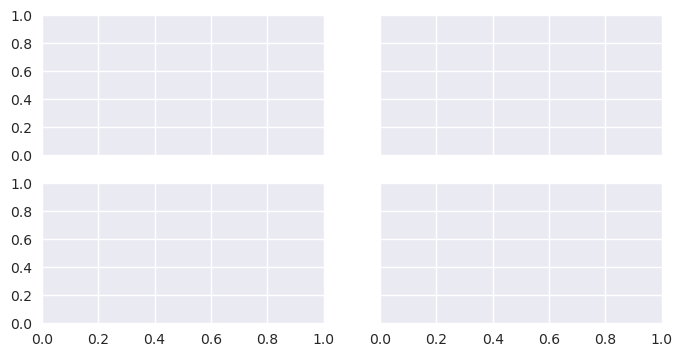

In [9]:
# def plot_diurnal(file,bin):
ds = xr.open_dataset(file)
fig,axes = plt.subplots(2,2,sharey=True,sharex=True,figsize=(8,4)) #,sharex=True,sharey='row'
df = ds['snowdepth'].to_pandas()

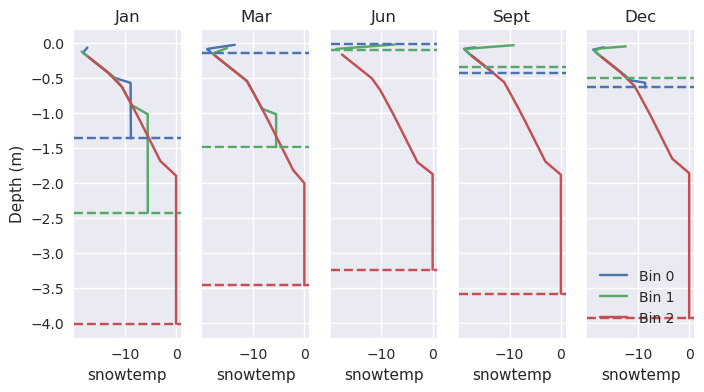

In [40]:
months_to_plot = np.int64(np.linspace(0,11,5))
plot_layers_monthly(file,'snowtemp',months_to_plot)
#plot_avgs(file,nyr)

In [57]:
fp = '/home/claire/research/PyGEM/pygem_eb/sample_init_data/endaccum_initialTp.nc'
ds = xr.open_dataset(fp)
print(ds.firn_depth)

<xarray.DataArray 'firn_depth' (bin_elev: 3)>
array([0, 0, 2])
Coordinates:
  * bin_elev  (bin_elev) float64 1.134e+03 1.381e+03 1.741e+03


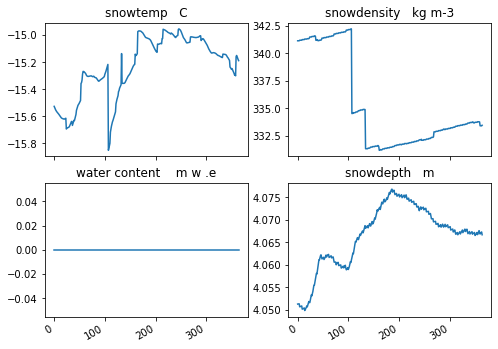

In [55]:
plot_avg_layers(file,bin,nyr)

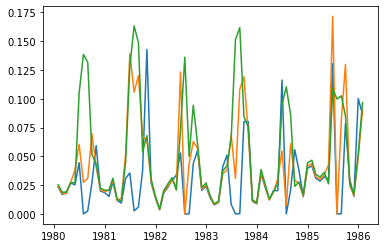

In [63]:
ds = xr.open_dataset(file)
accum = ds['accum'].to_pandas()
accum = accum.resample('M').mean()*1000
plt.plot(accum.index,accum)
plt.show()

In [107]:
import xarray as xr
ds = xr.open_dataset('/home/claire/research/climate_data/ERA5/ERA5_hourly/ERA5_precip_hourly.nc')
print(np.mean(ds['tp'].values),np.max(ds['tp'].values))
print(np.sum(ds['tp'].values[:8790]))

9.609282174515584e-05 0.004886787384748459
